### Quick Q & A

#### 1. Why create this notebook as we can run everything with the .py files in this folder?
Ans: Jupyter notebook is excellent for interation between coding and explanation.

#### 2. What's here?
Ans: Pretty much everything of the case study part in my final report. If you like a list, here it is:

- Part 1. Comparison btw CPU cases w/o JIT and w/ JIT (JIT: Just-in-Time compilation).
- Part 2. Comparison btw CPU and Numba CUDA for naive algorithm (JIT is now the default for everything below).
- Part 3. Comparison btw CPU and Numba CUDA for optimized algorithm.
- Part 4. Comparison btw CPU and Numba CUDA for optimized algorithm with lane changing.
- Part 5. Animation (If you like animation, scroll down to this part first).
- Part 6. Converge to equilibrium state.

#### 3. Will I see much code here? Suppose I don't like to see the lengthy code blocks.
Ans: No, only neat function calls will be included here. In case you want to know details of the coding part, check the .py files in this folder.

### API Call

Every time we do the simulation, we just run the following:

```
road, speed, accel = traffic_{suffix}(sim_steps, road_length, cell_size, traffic_density)
```

API ```traffic_{suffix}``` can be the following:
- ```traffic_cpu_nojit_naive```:  Naive algorithm based on CPU w/o JIT compilation.
- ```traffic_cpu_naive```:  Naive algorithm based on CPU w/ JIT compilation.
- ```traffic_cuda_naive```:  Naive algorithm based on CUDA (w/ JIT compilation by default for following programs).
- ```traffic_cpu```:  Optimized algorithm based on CPU.
- ```traffic_cuda```:  Optimized algorithm based on CUDA.
- ```traffic_cpu_lc```:  Optimized algorithm w/ lane changing based on CPU.
- ```traffic_cuda_lc```:  Optimized algorithm w/ lane changing based on CUDA.

Input parameter explanation:
- sim_steps: Total time steps for the simulation. Usually, it takes $10^2$ ~ $10^3$ steps for the traffic to converge to a steady state.
- road_length: Length of the road section, in unit kilometer (1 km ~ 0.6 mile).
- cell_size: The physical length represented by a cell, in unit meter (1 m ~ 3 ft). Recommend to use $\leq 1m$ for precision consideration.
- traffic_density: Number of vehicles on a unit length of road section for a single lane, in unit vehicles/km/lane. The max value is set to be 90 and any value higher than 90 will be set to 90 without warning.
- Others: other parameters not listed as the input include number of lanes (4), max speed (108km/h or 67mph), car size (5m), and etc. They can be found and editted in ```CONS.py```.

Return parameters:
- ```road```: An $NL \times NC$ matrix, where $NL$ is the number of lanes, $NC$ is the number of cells along the road and $NC = \frac{road \_ length}{cell \_ size} $. If there is a vehicle on a cell $i, j$, ```road[i][j]=vehicle_id```, otherwise ```road[i][j]=0```. ```vehicle_id``` is a unique number assigned to a vehicle created at $time = 0$ and ranges from $1$ to $N_v$, total number of vehicles. All vehicles will move from $j=0$ towards $j=NC-1$, but they will also come back to the starting side when passing $j=NC-1$, just like a ring. So an **equilibrium state** will be reached eventually.
- ```speed```: An $NL \times NC$ matrix storing speed of all the vehicles. ```speed[i][j]=v_k``` is the speed of the vehicle $k$ on cell ```road[i][j]```. If no vehicle on ```road[i][j]```, ```speed[i][j]=0```.
- ```accel```: An $NL \times NC$ matrix storing acceleration value of all the vehicles, like ```speed```.

Below are an example of ```road``` matrix:

<img src="imgs/road-demo.png" width="500">

### Part 1. Comparison btw CPU cases w/ & w/o JIT

C++ is quick because it compiles every line of code to machine code (0101010...) before running. Python is slow because it interpretes a line of code every time it is executed. If you have a 'for' loop, Python is really bad at it.

Now we have Numba, which compiles a python function and stores it in the cache for later reuse (the so called Just-in-Time compilation). This helps to speed the Python program to something near C++.  To do so, what we need to do is just add an '@njit' decorator to the python function. For example:
```
@njit
def Foo(a, b):
    return a + b
```

Let's now compare the performance of CPU code with and without JIT.

In [85]:
import numpy as np
from integrate_naive import traffic_cpu_nojit_naive, traffic_cpu_naive

# define parameters
sim_steps = 10 # Use 10 for shorter waiting time...
road_length = 10 # km
cell_size = 0.1 # m
traffic_density = 30 # veh/km/lane

Let's time the CPU code without JIT compilation.

In [86]:
%timeit road, speed, accel = traffic_cpu_nojit_naive(sim_steps, road_length, cell_size, traffic_density)

2.81 s ± 28.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Then time it with JIT compilation. Note: If you run it without the ```%timeit``` function, the first run can be slow because JIT has overhead in compilation. The acceleration will only be seen from the second run!

In [66]:
%timeit road, speed, accel = tcomparaffic_cpu_naive(sim_steps, road_length, cell_size, traffic_density)

9.2 ms ± 36 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


We can see that the case with JIT is more than **100x** faster. JIT compilation will the **default** in our following implementation for fair comparison btw CPU and GPU.

### Part 2. Comparison btw CPU and Numba CUDA for naive algorithm

For a small road section (1km), CPU is actually faster than CUDA because CUDA has memory transfer overhead.

In [81]:
import numpy as np
from integrate_naive import traffic_cpu_naive, traffic_cuda_naive

# define parameters
sim_steps = 100
road_length = 1
cell_size = 0.1
traffic_density = 30

In [5]:
# CPU
%timeit road, speed, accel = traffic_cpu_naive(sim_steps, road_length, cell_size, traffic_density)

876 µs ± 2.96 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [6]:
# CUDA
%timeit road, speed, accel = traffic_cuda_naive(sim_steps, road_length, cell_size, traffic_density)

7.98 ms ± 231 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


For more simulation steps and a larger road section (100km), now CUDA beats CPU.

In [7]:
sim_steps = 100
road_length = 100

In [8]:
%timeit road, speed, accel = traffic_cpu_naive(sim_steps, road_length, cell_size, traffic_density)

1.37 s ± 14 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [9]:
%timeit road, speed, accel = traffic_cuda_naive(sim_steps, road_length, cell_size, traffic_density)

186 ms ± 3.25 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Even though CUDA is faster now, there is a major problem of the naive algorithm: **warp divergence**, because each thread needs to operate on a cell, regardless of whether this cell has a vehicle or not. We will improve this in the following section.

P.S. To verify if CUDA gives us the correct answer, we can compare it with CPU outputs:

In [10]:
road_0, speed_0, accel_0 = traffic_cpu_naive(sim_steps, road_length, cell_size, traffic_density)
road, speed, accel = traffic_cuda_naive(sim_steps, road_length, cell_size, traffic_density)

In [11]:
# Check road matrices are identical
np.sum(np.array(road != road_0, dtype = np.bool))

0

In [12]:
# Check speed matrices are identical
np.sum(np.array(speed != speed_0, dtype = np.bool))

0

In [13]:
# Check acceleration matrices are identical
np.sum(np.array(accel != accel_0, dtype = np.bool))

0

### Part 3. Comparison btw CPU and Numba CUDA for optimized algorithm

We now develop an optimized algorithm. The general idea is to use two arrays ```pos_x``` and ```pos_y``` to store the positions of vehicles. It benefits both CPU and CUDA programs. For CPU, previously we need two ```for``` loops to check each cell in the road matrix, now we can directly access their positions without these ```for``` loops. For CUDA, previously we need to use 2D thread blocks to cover the entire ```road``` matrix, now we only need 1D thread blocks to cover ```pos_x``` and ```pos_y```, then there will be less overhead in launching blocks and also less warp divergence.

In [104]:
import numpy as np
from integrate import traffic_cpu, traffic_cuda

# define parameters
sim_steps = 100
road_length = 100
cell_size = 0.1
traffic_density = 30

In [71]:
%timeit road, speed, accel = traffic_cpu(sim_steps, road_length, cell_size, traffic_density)

840 ms ± 10.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [72]:
%timeit road, speed, accel = traffic_cuda(sim_steps, road_length, cell_size, traffic_density)

86.7 ms ± 275 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


We see a significant improvement compared with previous naive version. We further run more simulations and record the execution time. We will vary the ```road_length``` in the following case study. The ```sim_steps, cell_size, traffic_density``` will be fixed at 100, 0.1, and 30 respectively. 

In [106]:
import time
import numpy as np
from matplotlib import pyplot as plt
from integrate_naive import traffic_cpu_naive, traffic_cuda_naive

sim_steps = 100
cell_size = 0.1
traffic_density = 30

Remember to run the following cell **twice** for JIT to compile:

In [111]:
rls = [1, 5, 10, 20, 40, 100]
t_cpu_naive = []
t_cpu = []
t_cuda_naive = []
t_cuda = []

for rl in rls:
    # cpu, naive
    t0 = time.time()
    traffic_cpu_naive(sim_steps, rl, cell_size, traffic_density)
    t1 = time.time()
    t_cpu_naive.append(t1 - t0)
    
    # cpu, optimized
    t0 = time.time()
    traffic_cpu(sim_steps, rl, cell_size, traffic_density)
    t1 = time.time()
    t_cpu.append(t1 - t0)
    
    # cuda, naive
    t0 = time.time()
    traffic_cuda_naive(sim_steps, rl, cell_size, traffic_density)
    t1 = time.time()
    t_cuda_naive.append(t1 - t0)
    
    # cuda, optimized
    t0 = time.time()
    traffic_cuda(sim_steps, rl, cell_size, traffic_density)
    t1 = time.time()
    t_cuda.append(t1 - t0)

We first do an overall comparison:

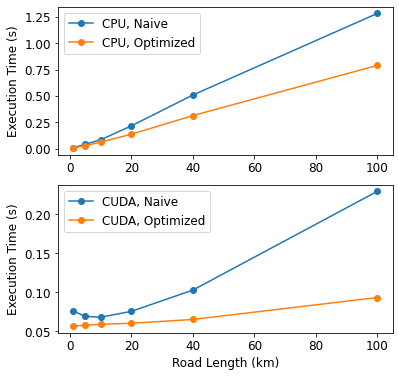

In [112]:
fig = plt.figure(figsize = (6, 6))
ax = fig.add_subplot(211)
ax.plot(rls, t_cpu_naive, marker = 'o', label = 'CPU, Naive')
ax.plot(rls, t_cpu, marker = 'o', label = 'CPU, Optimized')
ax.set_ylabel('Execution Time (s)')
# ax.set_xlabel('Road Length (km)')
ax.legend()

ax1 = fig.add_subplot(212)
ax1.plot(rls, t_cuda_naive, marker = 'o', label = 'CUDA, Naive')
ax1.plot(rls, t_cuda, marker = 'o',  label = 'CUDA, Optimized')
ax1.set_ylabel('Execution Time (s)')
ax1.set_xlabel('Road Length (km)')
ax1.legend()
# plt.savefig("naive-op.png", dpi=150)

Optimized algorithm is almost twice faster than the naive version, for both CPU and CUDA.

For the optimized version, let's take a look at how much faster CUDA is to CPU.

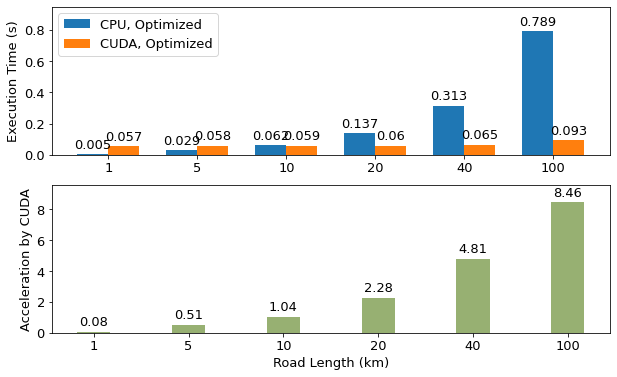

In [114]:
def autolabel(ax, rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

plt.rc('font', size=13) 
fig = plt.figure(figsize = (10, 6))
ax = fig.add_subplot(211)

width = 0.35  # the width of the bars
labels = [str(rl) for rl in rls]
x = np.arange(len(labels))  # the label locations
t_cpu_rd = [round(t, 3) for t in t_cpu]
t_cuda_rd = [round(t, 3) for t in t_cuda]

rects1 = ax.bar(x - width/2, height = t_cpu_rd, width = width, label = 'CPU, Optimized')
rects2 = ax.bar(x + width/2, height = t_cuda_rd, width = width, label = 'CUDA, Optimized')
# ax.set_xlabel('Road Length (km)')
ax.set_ylabel('Execution Time (s)')
ax.set_ylim(0, max(t_cpu) * 1.2)
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
autolabel(ax, rects1)
autolabel(ax, rects2)

                 
ratio = [round(t_cpu[i]/t_cuda[i],2) for i in range(len(labels))]
ax1 = fig.add_subplot(212)
rect = ax1.bar(x, height = ratio, width = 0.35, label = 'Ratio', color = '#97b072')
ax1.set_xlabel('Road Length (km)')
ax1.set_ylabel('Acceleration by CUDA')
ax1.set_ylim(0, int(max(ratio)) * 1.2)
ax1.set_xticks(x)
ax1.set_xticklabels(labels)
autolabel(ax1, rect)
# plt.savefig("re-op.png", dpi=150)

When road length > 10km, CUDA is faster than CPU, even ~10x faster for the 100km case.

### Part 4. Comparison btw CPU and Numba CUDA for optimized algorithm with lane changing

If **lane changing** is included, extra safety checking is required, this is nothing but memory read. We expect more superior performance for CUDA.

In [115]:
import time
import numpy as np
from matplotlib import pyplot as plt
from integrate import traffic_cpu_lc, traffic_cuda_lc

# define parameters
sim_steps = 100
road_length = 100
cell_size = 0.1
traffic_density = 30

Do some initial tests:

In [53]:
%timeit road, speed, accel = traffic_cpu_lc(sim_steps, road_length, cell_size, traffic_density)

2.32 s ± 88.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [54]:
%timeit road, speed, accel = traffic_cuda_lc(sim_steps, road_length, cell_size, traffic_density)

185 ms ± 4.31 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Run more cases:

In [116]:
rls = [1, 5, 10, 20, 40, 100]
t_cpu = []
t_cuda = []

for rl in rls:
    # cpu, optimized
    t0 = time.time()
    traffic_cpu_lc(sim_steps, rl, cell_size, traffic_density)
    t1 = time.time()
    t_cpu.append(t1 - t0)

    
    # cuda, optimized
    t0 = time.time()
    traffic_cuda_lc(sim_steps, rl, cell_size, traffic_density)
    t1 = time.time()
    t_cuda.append(t1 - t0)

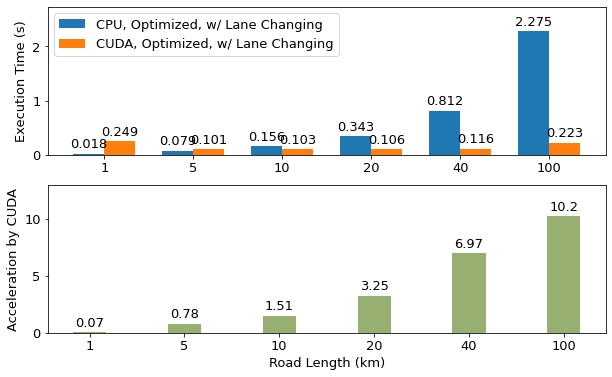

In [117]:
def autolabel(ax, rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

plt.rc('font', size=13) 
fig = plt.figure(figsize = (10, 6))
ax = fig.add_subplot(211)

width = 0.35  # the width of the bars
labels = [str(rl) for rl in rls]
x = np.arange(len(labels))  # the label locations
t_cpu_rd = [round(t, 3) for t in t_cpu]
t_cuda_rd = [round(t, 3) for t in t_cuda]

rects1 = ax.bar(x - width/2, height = t_cpu_rd, width = width, label = 'CPU, Optimized, w/ Lane Changing')
rects2 = ax.bar(x + width/2, height = t_cuda_rd, width = width, label = 'CUDA, Optimized, w/ Lane Changing')
# ax.set_xlabel('Road Length (km)')
ax.set_ylabel('Execution Time (s)')
ax.set_ylim(0, max(t_cpu) * 1.2)
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
autolabel(ax, rects1)
autolabel(ax, rects2)

                 
ratio = [round(t_cpu[i]/t_cuda[i],2) for i in range(len(labels))]
ax1 = fig.add_subplot(212)
rect = ax1.bar(x, height = ratio, width = 0.35, label = 'Ratio', color = '#97b072')
ax1.set_xlabel('Road Length (km)')
ax1.set_ylabel('Acceleration by CUDA')
ax1.set_ylim(0, int(max(ratio)) * 1.3)
ax1.set_xticks(x)
ax1.set_xticklabels(labels)
autolabel(ax1, rect)
# plt.savefig("re-op-lc.png", dpi=150)

CUDA still beats CPU, and the acceleration is slightly more than the previous cases without lane changing.

### Part 5. Animation

To create an animation, you need to have ```celluloid``` package. Use this command:
```
pip install celluloid
```
If you don't want this package, an animation is already included in ```imgs/animation.gif```, as shown in the bottom.

In [10]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import colors
from celluloid import Camera
from integrate import traffic_cpu_lc

road_length = 0.1 # use a small length for better demo
cell_size = 1
traffic_density = 30

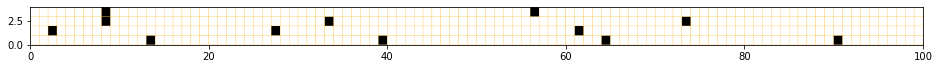

In [12]:
steps = list(range(20))
fig = plt.figure(figsize=(16, 0.7))
ax = fig.add_subplot(111)
camera = Camera(fig)
for step in steps:
    road, _, _ = traffic_cpu_lc(step, road_length, cell_size, traffic_density)
    r = np.array(road, dtype = np.bool)
    cmap = colors.ListedColormap(['white', 'black'])
    ax.pcolor(r, cmap = cmap, edgecolors='orange', linewidths=0.2)
    camera.snap()
animation = camera.animate()
animation.save('imgs/animation.gif', writer = 'imagemagick')

If you have created a new .git image from the above code cell, double-click the image below, and run the HTML code again to see your updates.

<img src="imgs/animation.gif" width="1300">

### Part 6.  Converge to equilibrium state

We are also interested in how much time steps it takes to converge to an equilibrium state.

In [58]:
import numpy as np
from matplotlib import pyplot as plt
from integrate import traffic_cpu_lc

road_length = 0.5
cell_size = 0.1
traffic_density = 30

In [61]:
speeds = []
steps = list(range(100))
for step in steps:
    road, speed, accel = traffic_cpu_lc(step, road_length, cell_size, traffic_density)
    ncar = np.sum(np.array(road, dtype = np.bool))
    vm = np.sum(speed)/ncar * 3.6
    speeds.append(vm)

Text(0, 0.5, 'Average speed (km/h)')

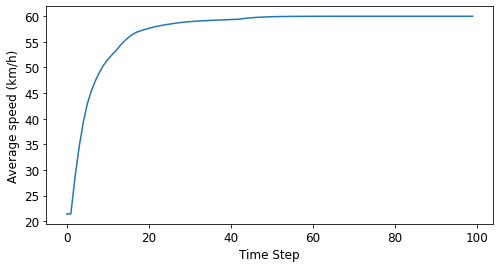

In [62]:
plt.rc('font', size=12)
fig = plt.figure(figsize=(8, 4))
ax = fig.add_subplot(111)
ax.plot(steps, speeds)
ax.set_xlabel('Time Step')
ax.set_ylabel('Average speed (km/h)')

We can see, the system converges at ~ 50 time steps (Each time step is 0.1s).